# European Spread Call Option with Stochastic Volatility

<b> YouTube Tutorial </b> (Published: Apr 8, 2022): https://youtu.be/EI8oblQ2Pvk

One of the main benefits of Monte Carlo simulations is to price options under multiple factors. By this I refer to multiple underlying asset prices or stochastic volatility or even changing interest rates.

In this tutorial we will explore the pricing of a European Spread Call Option on the difference between two stock indices $S_1$ and $S_2$ following a more general stochastic process. The SDE's will be have stochastic volatility as described by the Heston Model (1993):

<i>Underlying SDE's under risk-neutral measure:
<center>
$\large dS_{1,t} = (r-\delta_1) S_{1,t} dt + \sqrt{v_{1,t}} S_{1,t} dW^\mathbb{Q}_{1,t}$</center>
<center>
$\large dS_{2,t} = (r-\delta_2) S_{2,t} dt + \sqrt{v_{2,t}} S_{2,t} dW^\mathbb{Q}_{2,t}$</center>

<i>Variance Process:
<center>
$\large dv_{1,t} = \kappa_1 (\theta_2 - v_{1,t})dt + \sigma_1 \sqrt{v_{1,t}} dW^\mathbb{Q}_{3,t}$</center>
<center>$\large dv_{2,t} = \kappa_2 (\theta_2 - v_{2,t})dt + \sigma_2 \sqrt{v_{2,t}} dW^\mathbb{Q}_{4,t}$</center>



The Monte Carlo procedure is exactly the same for a spread call option except the correlation matrix between Wiener processes is larger, as in we have four correlated normal variates to simulate the four processes.
    
<i>Where:
       
$\large \rho_{W^\mathbb{Q}} = \begin{vmatrix}
1 & \rho_{12} & \rho_{13} & \rho_{14} \\
\rho_{12} & 1 & \rho_{23} & \rho_{24} \\
\rho_{13} & \rho_{23} & 1 & \rho_{34} \\
\rho_{14} & \rho_{24} & \rho_{34} & 1  \notag
\end{vmatrix} $
    
    
Notation:
- $S_t$ Equity spot price, financial index
- $v_t$ Variance.
- $C$ European call option price.
- $K$ Strike price.
- $W_{1,2}$ Standard Brownian movements.
- $r$ Interest rate.
- $\delta$ discrete dividend payment
- $\kappa$ Mean reversion rate.
- $\theta$ Long run variance.
- $v_0$ Initial variance.
- $\sigma$ Volatility of variance.
- $\rho$ Correlation parameter.
- $t$ Current date.
- $T$ Maturity date.

## Example of Nasdaq vs S&P500 Index

A while back we discussed how to futures or options could be used to speculate on the divergence between the spread of the NASDAQ and S&P500 Indices. We follow on this example by incorperating stochastic volatility.

In [ ]:
import numpy as np
from time import time
from scipy.linalg import cholesky

# Parameters - as of 1-Mar-22
SP500 = 4373.94
NASD = 	13751.40
div_SP500 = 0.0127
div_NASD = 0.0126
K = 9377 # current difference between index points
T = 1
r = 0.01828 # 10yr US Treasury Bond Yield

# Heston Model Parameters - made up for the example,
# we have discussed how to complete this step in a previous video using market option prices
theta1 = 0.02
theta2 = 0.03
kappa1 = 0.1
kappa2 = 0.12
sigma1 = 0.05
sigma2 = 0.06

# initial variances
vt10 = 0.03
vt20 = 0.03

# Correlation matrix between wiener process under risk-neutral measure
rho = np.array([[1,0.5,0.15,0.02],
                [0.5,1,0.01,0.25],
                [0.15,0.01,1,0.2],
                [0.02,0.25,0.2,1]])

### Slow Implementation
Let's first understand the implementation process

In [ ]:
# Monte Carlo Specific Parameters
N = 100    # discrete time steps
M = 1000   # number of simulations

# Start Timer
start_time = time()

# Precompute constants
dt = T/N

# log normal prices
lnS1 = np.log(NASD)
lnS2 = np.log(SP500)

# Heston model adjustments for time steps
kappa1dt = kappa1*dt
kappa2dt = kappa2*dt
sigma1sdt = sigma1*np.sqrt(dt)
sigma2sdt = sigma2*np.sqrt(dt)
vt1 = vt10
vt2 = vt20

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    # for each simulation i in M
    lnSt1 = lnS1
    lnSt2 = lnS2

    for j in range(N):
        # for each time step j in N

        # Generate correlated Wiener variables
        Z = np.random.normal(0.0, 1.0, size=(4))
        W = Z @ lower_chol

        # Simulate variance processes
        vt1 = vt1 + kappa1dt*(theta1 - vt1) + sigma1sdt*np.sqrt(vt1)*W[2]
        vt2 = vt2 + kappa2dt*(theta2 - vt2) + sigma2sdt*np.sqrt(vt2)*W[3]

        # Simulate log asset prices
        nu1dt = (r - div_NASD - 0.5*vt1)*dt
        nu2dt = (r - div_SP500 - 0.5*vt2)*dt

        lnSt1 = lnSt1 + nu1dt + np.sqrt(vt1*dt)*W[0]
        lnSt2 = lnSt2 + nu2dt + np.sqrt(vt2*dt)*W[1]

    St1 = np.exp(lnSt1)
    St2 = np.exp(lnSt2)

    CT = max(0, (St1 - St2) - K)

    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
print("Calculation time: {0} sec".format(round(time() - start_time,2)))

Call value is $750.31 with SE +/- 40.38
Calculation time: 2.14 sec


### Fast Implementation
Vectorizing option pricing

In [ ]:
# Monte Carlo Specific Parameters
N = 100    # discrete time steps
M = 1000   # number of simulations

# Start Timer
start_time = time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappa1dt = kappa1*dt
kappa2dt = kappa2*dt
sigma1sdt = sigma1*np.sqrt(dt)
sigma2sdt = sigma2*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate correlated Wiener variables
Z = np.random.normal(0.0, 1.0, size=(N,M,4))
W = Z @ lower_chol

# arrays for storing prices and variances
lnSt1 = np.full(shape=(N+1,M), fill_value=np.log(NASD))
lnSt2 = np.full(shape=(N+1,M), fill_value=np.log(SP500))
vt1 = np.full(shape=(N+1,M), fill_value=vt10)
vt2 = np.full(shape=(N+1,M), fill_value=vt20)

for j in range(1,N+1):

    # Simulate variance processes
    vt1[j] = vt1[j-1] + kappa1dt*(theta1 - vt1[j-1]) + sigma1sdt*np.sqrt(vt1[j-1])*W[j-1,:,2]
    vt2[j] = vt2[j-1] + kappa2dt*(theta2 - vt2[j-1]) + sigma2sdt*np.sqrt(vt2[j-1])*W[j-1,:,3]

    # Simulate log asset prices
    nu1dt = (r - div_NASD - 0.5*vt1[j])*dt
    nu2dt = (r - div_SP500 - 0.5*vt2[j])*dt

    lnSt1[j] = lnSt1[j-1] + nu1dt + np.sqrt(vt1[j]*dt)*W[j-1,:,0]
    lnSt2[j] = lnSt2[j-1] + nu2dt + np.sqrt(vt2[j]*dt)*W[j-1,:,1]

St1 = np.exp(lnSt1)
St2 = np.exp(lnSt2)

# Compute Expectation and SE
CT = np.maximum(0, (St1[-1] - St2[-1]) - K)
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
SE= sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
print("Calculation time: {0} sec".format(round(time() - start_time,2)))

Call value is $911.94 with SE +/- 46.58
Calculation time: 0.03 sec


### Visualisation

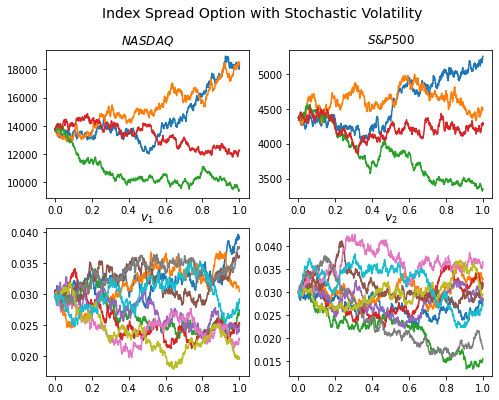

In [ ]:
import matplotlib.pyplot as plt
t = np.linspace(0,1,len(St1))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
ax[0,0].plot(t,St1[:,:4])
ax[0,0].set_title('$NASDAQ$')
ax[0,1].plot(t,St2[:,:4])
ax[0,1].set_title('$S&P500$')
ax[1,0].plot(t,vt1[:,:10])
ax[1,0].set_title('$v_1$')
ax[1,1].plot(t,vt2[:,:10])
ax[1,1].set_title('$v_2$')

fig.suptitle("Index Spread Option with Stochastic Volatility", fontsize=14)
plt.show()
